In [16]:
import Data_Simulator as ds

ds.sim_data

,GlobalDefectRate,AbsVolDeviation,AisleHoldPct,NumPickEvents,NumPickEventsClique,NumPicks,NumPicksClique,DefectInRelatedReceive,TimeInLocation,CurrentMaxVolume,Storage_M,Storage_S,Storage_XS,Defect
0,0.012363,3.261175,0.00,11,13,8,43,0,5.0,56.142236,True,False,False,0
1,0.006493,0.863345,0.00,1,21,27,44,0,6.0,19.121542,False,True,False,0
2,0.014716,1.547316,0.04,25,7,10,36,0,9.0,24.794522,False,True,False,0
3,0.009960,0.676915,0.00,7,1,4,40,0,2.0,37.773081,False,False,False,0
4,0.015507,3.047066,0.04,2,6,25,23,0,5.0,29.425188,True,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.000000,0.609795,0.00,4,1,34,12,0,8.0,28.353516,False,False,False,0
9996,0.021814,0.361120,0.00,7,2,0,22,0,4.0,11.061271,False,True,False,1
9997,0.009446,1.058161,0.06,1,15,17,19,0,9.0,21.732961,True,False,False,0
9998,0.015408,1.451685,0.04,5,7,8,39,0,5.0,26.959386,True,False,False,1


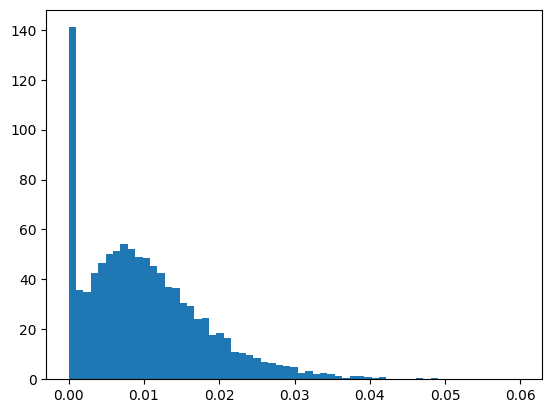

In [17]:
import matplotlib.pyplot as plt

plt.hist(ds.sim_data['GlobalDefectRate'], density=True, bins='auto')
plt.show()

In [22]:
import numpy as np
import pandas as pd
from scipy import stats

# your 1D data as a NumPy array
data = np.asarray(ds.sim_data['GlobalDefectRate'])

# list of candidate continuous distributions in scipy.stats
candidate_dists = {
    "norm": stats.norm,
    "lognorm": stats.lognorm,
    "expon": stats.expon,
    "gamma": stats.gamma,
    "beta": stats.beta
    # add more if needed
}

results = []

for name, dist in candidate_dists.items():
    # 1. Fit distribution parameters by MLE
    params = dist.fit(data)

    # scipy parameter convention: shape(s), loc, scale
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # 2. Compute log-likelihood
    logpdf = dist.logpdf(data, *arg, loc=loc, scale=scale)
    loglik = np.sum(logpdf)

    # number of free parameters (rough count)
    k = len(params)

    # 3. AIC (lower is better)
    aic = 2 * k - 2 * loglik

    # 4. Kolmogorov–Smirnov GOF test against fitted dist
    #    (null: data come from this dist)
    ks_stat, ks_p = stats.kstest(data, name, args=params)

    results.append({
        "dist": name,
        "params": params,
        "loglik": loglik,
        "aic": aic,
        "ks_stat": ks_stat,
        "ks_p": ks_p
    })

results_df = pd.DataFrame(results).sort_values("aic")
print(results_df)


c:\Users\myfir\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_continuous_distns.py:6120: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\myfir\AppData\Roaming\Python\Python311\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\myfir\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_continuous_distns.py:719: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


      dist                                             params         loglik  \
1  lognorm  (228.26045864746195, -5e-324, 4.75030728981749...  767880.132596   
3    gamma  (0.5082479275368619, -3.721915181384495e-25, 0...   59740.928322   
4     beta  (0.8389723065572633, 50.60255652211305, -5.525...   47075.140828   
2    expon                        (0.0, 0.010108162989277256)   35944.119648   
0     norm        (0.010108162989277256, 0.00811239786470726)   33954.232537   

            aic   ks_stat           ks_p  
1 -1.535754e+06  0.519451   0.000000e+00  
3 -1.194759e+05  0.184603  9.373106e-299  
4 -9.414228e+04  0.178640  1.174555e-279  
2 -7.188424e+04  0.106600   2.083840e-99  
0 -6.790447e+04  0.106380   5.354689e-99  


## Raw probabilities to logit

In [20]:
import numpy as np

eps = 1e-6
p = np.clip(data, eps, 1-eps)
z = np.log(p / (1 - p))   # logit transform
z

array([-4.38061665, -5.03048438, -4.20396293, ..., -4.65267091,
       -4.15734836, -4.34720495])

## Box-Cox transform for right skewed data

Best lambda: -0.01152385334113136


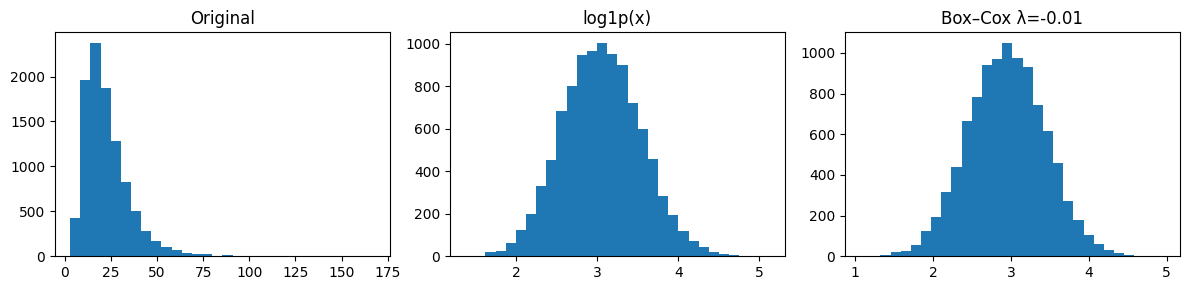

In [25]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

x = ds.sim_data['CurrentMaxVolume']

# 1) Try log transform
x_log = np.log1p(x)  # log(1 + x)

# 2) Let Box–Cox find best power
x_bc, best_lambda = stats.boxcox(x)  # x must be > 0
print("Best lambda:", best_lambda)

fig, axs = plt.subplots(1, 3, figsize=(12, 3))
axs[0].hist(x, bins=30);      axs[0].set_title("Original")
axs[1].hist(x_log, bins=30);  axs[1].set_title("log1p(x)")
axs[2].hist(x_bc, bins=30);   axs[2].set_title(f"Box–Cox λ={best_lambda:.2f}")
plt.tight_layout()
plt.show()
